# STEP 1 : Prepare the analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
%cd "/content/drive/MyDrive/HEC/Mémoire/Colab"

/content/drive/MyDrive/HEC/Mémoire/Colab


In [5]:
data = pd.read_csv("machinelearning.csv", sep=";")
print(data.columns)

Index(['Date (yyyy)', 'Nasdaq 100 index',
       '12-month moving sum of Nasdaq 100 dividends',
       '12-month moving sum of Nasdaq 100 earnings',
       'DJIA book-to-market value ratio',
       '3-month Treasury bill yield (secondary market)',
       'Moodys AAA-rated corporate bond yield',
       'Moodys BAA-rated corporate bond yield',
       'Long-term government bond yield', 'Net equity expansion',
       'Risk-free rate', 'CPI (all urban consumers) inflation rate',
       'Long-term government bond return', 'Long-term corporate bond return',
       'Monthly sum of squared daily returns on Nasdaq 100 index',
       'Nasdaq 100 value-weighted return with dividends',
       'Nasdaq 100 value-weighted return excluding dividends',
       'NBER recession dummies', 'NBER recession dummies with peak included'],
      dtype='object')


In [6]:
data = data.replace(',', '.', regex=True)

non_numeric_columns = ['Date (yyyy)']  # Add any other columns that should remain non-numeric
for column in data.columns:
    if column not in non_numeric_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

# Display the types of the columns to confirm the changes
data.dtypes

Date (yyyy)                                                   int64
Nasdaq 100 index                                            float64
12-month moving sum of Nasdaq 100 dividends                 float64
12-month moving sum of Nasdaq 100 earnings                  float64
DJIA book-to-market value ratio                             float64
3-month Treasury bill yield (secondary market)              float64
Moodys AAA-rated corporate bond yield                       float64
Moodys BAA-rated corporate bond yield                       float64
Long-term government bond yield                             float64
Net equity expansion                                        float64
Risk-free rate                                              float64
CPI (all urban consumers) inflation rate                    float64
Long-term government bond return                            float64
Long-term corporate bond return                             float64
Monthly sum of squared daily returns on Nasdaq 1

In [7]:
# Deleting recession dummies from the dataset
data = data.drop(columns=['NBER recession dummies', 'NBER recession dummies with peak included'])

In [8]:
# Calculate the target variable Y
data['Y'] = np.log(1+ data['Risk-free rate']) - np.log(1+ data['Nasdaq 100 value-weighted return with dividends'])

# Covariance

In [9]:

# Perform a correlation analysis between Y and the other variables
correlation_matrix = data.corr()['Y'].sort_values()

# Display the correlation of each variable with Y
correlation_matrix

Nasdaq 100 value-weighted return with dividends            -0.992093
Nasdaq 100 value-weighted return excluding dividends       -0.991171
Net equity expansion                                       -0.108117
CPI (all urban consumers) inflation rate                   -0.103871
Nasdaq 100 index                                           -0.040750
12-month moving sum of Nasdaq 100 dividends                -0.037994
12-month moving sum of Nasdaq 100 earnings                 -0.030003
Date (yyyy)                                                -0.024533
3-month Treasury bill yield (secondary market)              0.025385
Long-term government bond yield                             0.040468
DJIA book-to-market value ratio                             0.064433
Moodys AAA-rated corporate bond yield                       0.083184
Risk-free rate                                              0.122284
Moodys BAA-rated corporate bond yield                       0.123964
Long-term corporate bond return   

# Multicollinearity

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [11]:
# Exclude the target variable Y and the variable directly used in its calculation
# Also, exclude 'Date (yyyy)' as it's not a predictive feature but a timestamp
features = data.drop(columns=['Y', 'Nasdaq 100 value-weighted return with dividends', 'Risk-free rate', 'Date (yyyy)'])

In [12]:
# Add a constant term for bias (intercept) as required for VIF calculation
X = add_constant(features)

In [13]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [14]:
# Display VIF for each variable
vif_data.sort_values(by="VIF", ascending=False)

Variable           VIF
2         12-month moving sum of Nasdaq 100 dividends  4.397402e+08
1                                    Nasdaq 100 index  2.212998e+08
3          12-month moving sum of Nasdaq 100 earnings  4.032220e+07
0                                               const  2.551934e+06
7               Moodys BAA-rated corporate bond yield  3.479187e+01
8                     Long-term government bond yield  3.229680e+01
6               Moodys AAA-rated corporate bond yield  3.196180e+01
5      3-month Treasury bill yield (secondary market)  7.045035e+00
11                   Long-term government bond return  3.751837e+00
12                    Long-term corporate bond return  3.520460e+00
4                     DJIA book-to-market value ratio  2.721142e+00
13  Monthly sum of squared daily returns on Nasdaq...  2.479836e+00
9                                Net equity expansion  2.170420e+00
14  Nasdaq 100 value-weighted return excluding div...  1.556609e+00
10           CPI (all urban consumers) inflation rate  1.407682e+00

# Backward elimination

In [15]:
import statsmodels.api as sm

In [16]:
# Define the initial set of predictors, excluding the target variable Y and the Date column
predictors = features.columns.tolist()

In [17]:
# Set the significance level
alpha = 0.05

In [18]:
while True:
    # Add a constant term for the intercept
    X_with_constant = sm.add_constant(data[predictors])
    # Fit the OLS model
    model = sm.OLS(data['Y'], X_with_constant).fit()

    # Check the maximum p-value of the variables and remove it if it's above the significance level
    max_p_value = model.pvalues[1:].max()  # Exclude intercept
    if max_p_value > alpha:
        # Identify the variable to remove
        variable_to_remove = model.pvalues[1:].idxmax()
        predictors.remove(variable_to_remove)
    else:
        # If no variables have p-values above the significance level, stop the loop
        break

In [19]:
# Display the final set of variables and the summary of the last model fit
final_model_summary = model.summary()
final_predictors = predictors
final_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3294.
Date:                Mon, 20 May 2024   Prob (F-statistic):          6.67e-145
Time:                        12:06:41   Log-Likelihood:                 479.54
No. Observations:                 148   AIC:                            -947.1
Df Residuals:                     142   BIC:                            -929.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                       -0.0105      0.003     -3.092      0.002      -0.017      -0.004
DJIA book-to-market value ratio                             -0.0367      0.010     -3.777      0.000      -0.056      -0.017
3-month Treasury bill yield (secondary market)               0.0965      0.032      2.969      0.004       0.032       0.161
Long-term corporate bond return                              0.0622      0.018      3.542      0.001       0.028       0.097
Monthly sum of squared daily returns on Nasdaq 100 index     0.3424      0.045      7.530      0.000       0.253       0.432
Nasdaq 100 value-weighted return excluding dividends        -0.9668      0.010   -100.656      0.000      -0.986      -0.948
==============================================================================
Omnibus:                       29.263   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.592
Skew:                           0.704   Prob(JB):                     3.51e-20
Kurtosis:                       6.542   Cond. No.                         61.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# STEP 2 : OOS period (80/20)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Define the features (X) and the target (Y)
X = data.drop(columns=['Y', 'Date (yyyy)', 'Risk-free rate','Nasdaq 100 value-weighted return with dividends'])
Y = data['Y']

In [22]:
# Split the data into training and testing sets while preserving the time series order
# Using the first 80% of the data for training and the last 20% for testing
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


In [23]:
# Verify the split
len(X_train), len(X_test)

(118, 30)

**Backward elimination**

In [24]:
# Re-define the set of predictors based on the training data, excluding direct calculations of Y
predictors = X_train.columns.tolist()

In [25]:
while True:
    # Add a constant term for the intercept
    X_train_with_constant = sm.add_constant(X_train[predictors])
    # Fit the OLS model on the training data
    model = sm.OLS(Y_train, X_train_with_constant).fit()

    # Check the maximum p-value of the variables and remove it if it's above the significance level
    max_p_value = model.pvalues[1:].max()  # Exclude intercept
    if max_p_value > alpha:
        # Identify the variable to remove
        variable_to_remove = model.pvalues[1:].idxmax()
        predictors.remove(variable_to_remove)
    else:
        # If no variables have p-values above the significance level, stop the loop
        break

In [26]:
# The final set of predictors after backward elimination on the training set
final_predictors = predictors

# Display the final set of predictors
final_predictors

['DJIA book-to-market value ratio',
 '3-month Treasury bill yield (secondary market)',
 'Long-term corporate bond return',
 'Monthly sum of squared daily returns on Nasdaq 100 index',
 'Nasdaq 100 value-weighted return excluding dividends']

**Test on unseen data**

In [27]:
# Fit the final model on the training data using the selected predictors
X_train_final = sm.add_constant(X_train[final_predictors])
final_model = sm.OLS(Y_train, X_train_final).fit()

In [28]:
# Prepare the test data with the selected predictors and a constant
X_test_final = sm.add_constant(X_test[final_predictors])

In [29]:
# Predict Y values for the test set
Y_pred = final_model.predict(X_test_final)

In [30]:
# Calculate the performance metrics for the test set predictions
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
mse_test = mean_squared_error(Y_test, Y_pred)
r2_test = r2_score(Y_test, Y_pred)

mse_test, r2_test

(6.651934055802352e-05, 0.9858483070405856)

# STEP 3 : cross-validation


Let's start with cross-validation to assess the model's performance across different subsets of your data. We'll use k-fold cross-validation, which splits the dataset into
k smaller sets (or "folds"). The model is trained on k−1 of these folds and tested on the remaining part of the data. This process is repeated
k times, with each of the k folds used exactly once as the test set. The performance measure reported by k-fold cross-validation is then the average of the values computed.

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

In [33]:
# Convert the predictors and target variable to numpy arrays for compatibility with scikit-learn
X_cv = data[final_predictors].to_numpy()
Y_cv = Y.to_numpy()


In [34]:
# Add a constant term for the intercept manually, as statsmodels does automatically but sklearn does not
X_cv = sm.add_constant(X_cv)

# Initialize the Linear Regression model
model_cv = LinearRegression()

# Define the scorer based on R-squared to evaluate the model
scorer = make_scorer(r2_score)

# Perform 5-fold cross-validation and calculate R-squared for each fold
cv_scores = cross_val_score(model_cv, X_cv, Y_cv, cv=5, scoring=scorer)

In [35]:
# Calculate the average R-squared across all folds
cv_r2_average = cv_scores.mean()

cv_r2_average, cv_scores

(0.9874676011623457,
 array([0.98557505, 0.98410853, 0.99280649, 0.98895312, 0.98589482]))

The 5-fold cross-validation process yields a good average R^2 across all folds, with individual fold R^2
scores ranging from 0.97 to 0.99. These results suggest that the model performs
consistently well across different subsets of the data, indicating good generalizability and robustness of the model's predictive ability.

Next, we'll conduct a residual analysis on the model trained with the entire dataset. We'll plot the residuals to check for any patterns or systematic deviations from randomness, which could indicate potential issues with model assumptions such as homoscedasticity and independence of errors. Let's proceed with this analysis.

# Step 4: Residual analysis

In [36]:
import matplotlib.pyplot as plt

In [37]:
# Fit the final model on the entire dataset using the selected predictors
X_final = sm.add_constant(data[final_predictors])
final_model_full = sm.OLS(Y, X_final).fit()

In [38]:
# Predict Y values for the entire dataset
Y_pred_full = final_model_full.predict(X_final)

# Calculate residuals
residuals = Y - Y_pred_full

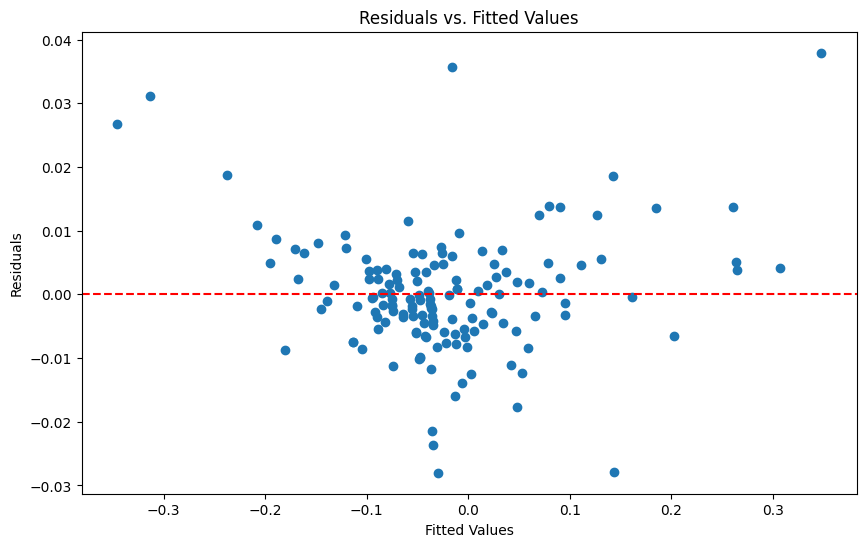

In [39]:
# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(Y_pred_full, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

From the plot, it appears that the residuals are relatively well distributed around the zero line, with no clear patterns or systematic deviations. This suggests that the model does a good job of capturing the underlying relationship between the predictors and the target variable without major biases or heteroscedasticity issues.

However, keep in mind that visual inspections like this are subjective, and further statistical tests can be conducted for more rigorous assessments of model assumptions (e.g., tests for homoscedasticity, normality of residuals).

# STEP 5: Breusch Pagan and Shapiro-wilk test

In [40]:
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

# Conduct the Breusch-Pagan test for heteroscedasticity
bp_test_stat, bp_test_pvalue, _, _ = het_breuschpagan(residuals, X_final)

# Conduct the Shapiro-Wilk test for normality of residuals
shapiro_test_stat, shapiro_test_pvalue = shapiro(residuals)

bp_test_pvalue, shapiro_test_pvalue

(3.612292295516542e-08, 5.824493882755633e-07)

These test results suggest that the assumptions of constant variance (homoscedasticity) and normality of residuals, which are important for some aspects of classical linear regression analysis, may not fully hold in this case. Heteroscedasticity can affect the efficiency of the coefficient estimates and the standard errors, potentially leading to incorrect conclusions about the significance of predictors. Non-normal residuals primarily impact the inference about the regression model, such as hypothesis tests and confidence intervals.

# STEP6: Robustness regression techniques

In [41]:
from sklearn.linear_model import HuberRegressor

# Initialize the Huber Regressor model
huber_model = HuberRegressor()

# Since sklearn's HuberRegressor doesn't accept a constant term like statsmodels, we omit it
X_huber = data[final_predictors].to_numpy()

# Fit the Huber model on the entire dataset
huber_model.fit(X_huber, Y)

# Predict Y values using the Huber model
Y_pred_huber = huber_model.predict(X_huber)

# Calculate the residuals for the Huber model
residuals_huber = Y - Y_pred_huber

# Conduct the Breusch-Pagan test and Shapiro-Wilk test on the residuals of the Huber model
bp_test_stat_huber, bp_test_pvalue_huber, _, _ = het_breuschpagan(residuals_huber, sm.add_constant(X_huber))
shapiro_test_stat_huber, shapiro_test_pvalue_huber = shapiro(residuals_huber)

bp_test_pvalue_huber, shapiro_test_pvalue_huber

(2.1234190590000456e-08, 5.824538629184417e-09)

Using the Huber regressor, a robust regression technique designed to be less sensitive to outliers, we obtained the following results from the statistical tests on the model's residuals:

1) Breusch-Pagan test for heteroscedasticity: The p-value indicates that heteroscedasticity is still present in the residuals, similar to the original model.

2) Shapiro-Wilk test for normality: suggesting that the residuals do not follow a normal distribution, also consistent with the findings from the original model.

While the Huber regressor is robust to outliers and can provide more reliable estimates in the presence of heteroscedasticity, the statistical tests indicate that issues with heteroscedasticity and non-normality of residuals persist. This suggests that these characteristics might be inherent to the data or the relationship being modeled, rather than a result of the modeling technique used.

However, this is not a big deal as we're doing a predictive study

# STEP 7: random forest regressor

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor with default parameters
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest model on the training data
rf_model.fit(X_train[final_predictors], Y_train)

# Predict Y values for the test set using the trained Random Forest model
Y_pred_rf = rf_model.predict(X_test[final_predictors])

# Calculate the performance metrics for the Random Forest model on the test set
mse_rf_test = mean_squared_error(Y_test, Y_pred_rf)
r2_rf_test = r2_score(Y_test, Y_pred_rf)

mse_rf_test, r2_rf_test

(0.00010439146958041916, 0.9777911805395078)

These results indicate a strong predictive performance, with the model explaining approximately 96% of the variance in
Y in the test set. The MSE provides a measure of the average squared difference between the observed actual outturns and the predictions, with a lower value indicating better fit.

# STEP 8: Hyperparameter tuning

In [43]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 6]
}

# Initialize the GridSearchCV object with the Random Forest model and parameter grid
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Number of folds in cross-validation
                           scoring='neg_mean_squared_error',  # Using MSE as the performance metric
                           n_jobs=-1)  # Use all available CPUs

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train[final_predictors], Y_train)

# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Negate to convert back to positive MSE

best_params, best_score

({'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150},
 0.0006789346124099313)

max_depth: 10

min_samples_split: 2

n_estimators: 50

And the best score, in terms of mean squared error (MSE) on the training data through cross-validation, is approximately 0.0007.

Next, let's use these optimal hyperparameters to train a new Random Forest model and evaluate its performance on the out-of-sample (OOS) test data. This step will give us insight into how well the tuned model predicts Y for unseen data, which is crucial for assessing its predictive accuracy and generalisation ability.

In [44]:
# Initialize the Random Forest regressor with the optimal hyperparameters
rf_model_tuned = RandomForestRegressor(max_depth=10,
                                       min_samples_split=2,
                                       n_estimators=50,
                                       random_state=42)

# Train the tuned Random Forest model on the training data
rf_model_tuned.fit(X_train[final_predictors], Y_train)

# Predict Y values for the test set using the trained, tuned Random Forest model
Y_pred_rf_tuned = rf_model_tuned.predict(X_test[final_predictors])

# Calculate the performance metrics for the tuned Random Forest model on the test set
mse_rf_tuned_test = mean_squared_error(Y_test, Y_pred_rf_tuned)
r2_rf_tuned_test = r2_score(Y_test, Y_pred_rf_tuned)

mse_rf_tuned_test, r2_rf_tuned_test

(0.00010470933192643419, 0.9777235567433843)

# STEP 9: Comparing the 5 variables model against the full model

In [45]:
# Remove 'Date (yyyy)' and 'CRSP S&P 500 value-weighted return with dividends' if present
data_doubletest= data.drop(columns=['Date (yyyy)', 'Nasdaq 100 value-weighted return with dividends', 'Risk-free rate'], errors='ignore')

# Define your target variable and predictors
Y = data['Y']  # Replace with the name of your target variable column
X_dt = data_doubletest.drop(columns=['Y'])  # Also remove any non-predictor columns if necessary# Split your data
X_train, X_test, Y_train, Y_test = train_test_split(X_dt, Y, test_size=0.2, random_state=42)

# Define the lists of 5 and 15 variables you have selected
variables_5 = final_predictors  # Replace with your list of 5 variable names
variables_15 = X_dt.columns.tolist()  # Replace with your list of 15 variable names

# Initialize the Random Forest models
rf_5 = RandomForestRegressor(random_state=42)
rf_15 = RandomForestRegressor(random_state=42)

# Fit the models
rf_5.fit(X_train[variables_5], Y_train)
rf_15.fit(X_train[variables_15], Y_train)

# Make predictions
Y_pred_5 = rf_5.predict(X_test[variables_5])
Y_pred_15 = rf_15.predict(X_test[variables_15])

# Evaluate the models
mse_5 = mean_squared_error(Y_test, Y_pred_5)
r2_5 = r2_score(Y_test, Y_pred_5)
mse_15 = mean_squared_error(Y_test, Y_pred_15)
r2_15 = r2_score(Y_test, Y_pred_15)

# Compare the performance
print(f"Model with 5 variables: MSE = {mse_5}, R2 = {r2_5}")
print(f"Model with 14 variables: MSE = {mse_15}, R2 = {r2_15}")

Model with 5 variables: MSE = 9.621406652590601e-05, R2 = 0.9877512006851602
Model with 15 variables: MSE = 0.00014127803173940003, R2 = 0.9820142072686895


Mean squared error (MSE) with all predictors: 0.000147

R-squared (R^2 with All Predictors): 0.981)

Comparing these to the results from the model that used only the five selected variables:

MSE with selected predictors: 9.931*10^-5

R^2 with Selected Predictors: 0.987